# M7 | Research Investigation Notebook

In this notebook, we will do a research investigation on Learnavi data. We start by stating our research question (1), then processing our data (1), creating different predictive model (2), and finally evaluating our models' results (3).


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and Mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

## 0 - Research Question

[Research question Google Doc](https://docs.google.com/document/d/192In6j2Mvgf9qK5lWxupOTO15M5YGBCbqpN4y4DoGIo/edit)

**Research question:** How are the users learning mathematics on Lernnavi? Are there differences between different topics? 

## 1 - Data Preprocessing

In this section, we perform all the preprocessing steps relevant for building our models. We also provide some visualizations of features / data explorations that are related to our downstream prediction task.

Here are the main preprocessing decision we made on our data:

* We consider only the mathematics part of Learnavi data. We assume that mathematics data and german data may behave very differently.
* We build a graph of mathematical topics. Our aim is to take the parent nodes as the skills and therefore we consider the leaves of a same parent node as training the same skill. We can then compare this approach with the one when we consider each leave as a skill.
* As we needed to have binary evaluations (either 0 or 1) for most of our models in the first setting, we decided to treat partially correct answers as wrong. This decision is supported by the fact that it is easier to be partially correct by chance (e.g. by ticking one of the correct answers by chance) than to accidentaly tick an incorrect choice when mastering a skill.

In [2]:
# ! pip install optuna
# ! pip install pyBKT
# ! pip install pymer4

In [3]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import tensorflow as tf
import optuna
import warnings

from optuna.samplers import TPESampler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from pyBKT.models import Model
from pymer4.models import Lmer
from helpers import *


# Mute warnings after checking that they are not a problem in our code
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_columns', 500)

DATA_DIR = './../data' # You may change the directory
RUN_OPTUNA = False # whether to run hyperparameter tuning (will take a long time if True)
SAVE_GRAPH = False # to avoid library issues; for exporting the graph image

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))
documents = pd.read_csv('{}/documents.csv.gz'.format(DATA_DIR))
topic_trees = pd.read_csv('{}/topic_trees.csv.gz'.format(DATA_DIR))
topics_translated = pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))

### 1.1 Graph of topics

We start by building a graph of the topics. They have a hierarchical structure which we will exploit in order to group similar topics together. This way we will avoid data sparsity.

In [4]:
math_topics = topics_translated[topics_translated.math == 1]
print("Number of math topics: ", math_topics.id.nunique())
math_topics.head()

Number of math topics:  298


,id,name,description,name_english,description_english,math
3,109,Mathematik,Rechnen und so...,mathematics,Expect and so ...,1.00000
4,950,Zahlen und Zahlenmengen,NaN,Numbers and number quantities,NaN,1.00000
5,951,Zahlenmengen,Die Schülerinnen und Schüler kennen die Zahlen...,Quantities,The students know the number of numbers and th...,1.00000
6,952,Brüche - Grundrechenarten,Die Schülerinnen und Schüler können Grundreche...,Breaks - Basic Computer,The students can perform basic work in the rat...,1.00000
7,953,"Brüche - Addition, Subtraktion",Sie können Additionen und Subtraktionen mit Br...,"Breaks - Addition, Subtraction",You can execute additions and subtractions wit...,1.00000


In [5]:
topic_trees.head()

,id,parent_id,child_id,sibling_rank,displayed_on_dashboard
0,1059,NaN,1,1,1
1,1060,NaN,109,109,1
2,1061,1.00000,2,0,1
3,1062,1.00000,2022,7,1
4,1063,"3,069.00000",2559,409,0


In [6]:
# Drop topics that should be deleted
math_topics = math_topics[~math_topics.name_english.str.contains('delete')]
math_topics_ids = math_topics.id.unique()

# Filter out edges where neither of the nodes are maths-related
math_topic_trees = topic_trees[topic_trees['parent_id'].isin(math_topics_ids) | topic_trees['child_id'].isin(math_topics_ids)]

In [7]:
# Build the graph
source = [x for x in math_topic_trees.parent_id.dropna().tolist() if x in math_topics_ids]
dest = [x for x in math_topic_trees.child_id.tolist() if x in math_topics_ids]
edges = list(zip(source, dest))

G = nx.DiGraph()
G.add_edges_from(edges)
G.remove_edges_from(list(nx.selfloop_edges(G))) # remove self-loops

In [8]:
# Mappings to navigate from topic_id to topic_name and vice-versa
id_to_name = math_topics.set_index('id')['name_english'].to_dict()
name_to_id = math_topics.set_index('name_english')['id'].to_dict()

In [9]:
if SAVE_GRAPH:
    # save as an image for inspection
    H = G.copy()
    H = nx.relabel_nodes(H, id_to_name)
    p = nx.drawing.nx_pydot.to_pydot(H)   
    p.write_png('img/topics.png')

The resulting graph can be previewed [here](img/topics.png).

### 1.2 Build dataframes of trials that fit the KT framework

Here we build dataframes of trials that fit for the different knowledge tracing models and settings.  

**(1.2.1)** From the tables provided by Learnavi, we first gather the information relevant for our analysis by merging the `documents` containing the topic of the questions with the `events` corresponding to submissions from users with the `transactions` where we can find the evaluation of the submission on the document.  

**(1.2.2)** We also add the difficulty of each question (estimated by Learnavi) for each trials. This feature can be used in the logistic models (AFM and PFA) and DKT.

**(1.2.3)** The evaluation provided by Learnavi tables are categorical ("WRONG", "PARTIAL", "CORRECT"), but to fit knowledge tracing model we need mainly Integers or Floats.
Hence we build two dataframes:

* One dataframe with a binary evaluation {0, 1}, considering partially correct answers as wrong (**binary setting**)
* And one dataframe with a "ternary" evaluation {0, 0.5, 1}, taking into account partially correct answers. This dataframe could be used with slightly modified models (**partial credit setting**)

**(1.2.4)** Finally, We complete our dataframes with the information that AFM and PFA requires, namely the number of previous attempts realised by a user on a same topic (for AFM) and the number of correctly and incorrectly solved exercices by a user on a same topic (for PFA). We do the same processing for the partial credit setting with the corresponding adaptation.

#### 1.2.1 Dataframe of trials with topic & evaluation informations

For each `document_id`, there are multiple entries in the `documents` table corresponding to different versions of the document. However, each `document_id` corresponds to a unique topic. Thus, we can group by the document ID and keep the first topic.

In [10]:
# Get all topic_ids for each document_id
topics_per_doc = documents.groupby('document_id')['topic_id'] \
                          .apply(set) \
                          .to_frame() 

# Check that there are no documents with the same ID but different topic
multitopic = [x for x in topics_per_doc.topic_id.values if len(x) > 1] # indicator for documents with multiple topics 
assert len(multitopic) == 0

In [11]:
# Get a mapping document_id => topic (the only set element from topics_per_doc)
topic_per_doc = topics_per_doc.topic_id.apply(lambda x: list(x)[0])

We filter the events that correspond to question answering (i.e. trials).

In [12]:
answer_events = events[(events.action == 'SUBMIT_ANSWER')]

Now we can form the `trials_df` dataframe with the information from the events (for the trials), the transaction (for the evaluation) and the documents (for the topic).

In [13]:
trials_df = answer_events.merge(transactions, on = 'transaction_token', suffixes=['', '_2']) \
                         .merge(topic_per_doc, on = 'document_id') \
                         .drop(columns=['user_id_2','action'])

#### 1.2.2 Add the estimated difficulty of each document

In [14]:
# Get the content for each document_id
difficulty_per_doc = documents.groupby('document_id')['content'] \
                              .apply(set) \
                              .to_frame()

# Get a mapping document_id => content (the only set element from difficulty_per_doc)
difficulty_per_doc = difficulty_per_doc.content.apply(lambda x: list(x)[0]).to_frame()

# Retrieve the difficulty from documents metadata (content)
difficulty_per_doc['difficulty'] = difficulty_per_doc['content'].apply(lambda doc: get_difficulty(doc))

In [15]:
# Add the difficulty of the document used for each trial
trials_df = trials_df.merge(difficulty_per_doc[['difficulty']], on='document_id')

#### 1.2.3 Map the evaluation categories to integer

Finally, we map the evaluation from categories to integers to fit KT framework. We distinguish two cases, `trials_bin_df` which only considers CORRECT and WRONG answers (treating PARTIAL answers as WRONG) and `trials_partial_df` which also takes into account PARTIAL answers.

In [16]:
def map_grading(df, grading = {'CORRECT': 1, 'WRONG': 0, 'PARTIAL': 0}):
    """
    Params:
        df (pd.DataFrame): 
            Dataframe with a categorical evaluation column.
        grading (dict): 
            Mapping for the evaluations (to integers).
    Returns:
        pd.DataFrame: 
            Dataframe with evaluation pre-processed for KT.
    """
    # Remove entries where evaluation is N/A & map them according to the grading
    df = df.dropna(subset = ['evaluation'])
    df['evaluation'] = df['evaluation'].map(grading)
    
    return df

In [17]:
USEFUL_FEATURES = ['user_id', 'commit_time', 'topic_id', 'difficulty', 'evaluation']

trials_bin_df = map_grading(trials_df)[USEFUL_FEATURES]
trials_partial_df = map_grading(trials_df, {'CORRECT': 1, 'WRONG': 0, 'PARTIAL': 0.5})[USEFUL_FEATURES]

#### 1.2.4 Perform preprocessing specific to AFM & PFA

AFM and PFA are models that compute the probability of a user to solve a task correctly based on their overall previous attempts (for AFM) and on their correct and wrong previous attempts (for PFA).
We hence compute those three variables for trials_df.

In [18]:
# Compute the overall number of previous attempts
trials_bin_df['one'] = 1
trials_bin_df['prev_attempts'] = (
    trials_bin_df.sort_values('commit_time')
                 .groupby(by=['user_id','topic_id'])['one']
                 .cumsum() - 1
)

# Compute the number of correct and wrong previous attempts
trials_bin_df['correct_attempts'] = (
    trials_bin_df.sort_values('commit_time')
                 .groupby(by=['user_id','topic_id'])['evaluation']
                 .cumsum()
)
trials_bin_df['prev_correct_attempts'] = (
    trials_bin_df.sort_values('commit_time')
                 .groupby(by=['user_id','topic_id'])['correct_attempts']
                 .shift(periods=1, fill_value=0)
)
trials_bin_df['prev_wrong_attempts'] = trials_bin_df['prev_attempts'] - trials_bin_df['prev_correct_attempts']

# Remove temporary variables
trials_bin_df.drop(['one', 'correct_attempts'], axis=1, inplace=True)

Taking now into account partially correct answers, we compute the correct, partially correct and wrong previous attempts for trials_df. We will use these features to extend PFA in order to compute the probability of a user to solve a task correctly.

In [19]:
# Compute the overall number of previous attempts
trials_partial_df['one'] = 1
trials_partial_df['prev_attempts'] = (
    trials_partial_df.sort_values('commit_time')
                     .groupby(by=['user_id','topic_id'])['one']
                     .cumsum() - 1
)

trials_partial_df['is_correct'] = trials_partial_df.apply(lambda x: 1 if x.loc['evaluation'] == 1 else 0, axis=1)
trials_partial_df['is_wrong'] = trials_partial_df.apply(lambda x: 1 if x.loc['evaluation'] == 0 else 0, axis=1)

# Compute the number of correct previous attempts
trials_partial_df['correct_attempts'] = (
    trials_partial_df.sort_values('commit_time')
                     .groupby(by=['user_id','topic_id'])['is_correct']
                     .cumsum()
)
trials_partial_df['prev_correct_attempts'] = (
    trials_partial_df.sort_values('commit_time')
                     .groupby(by=['user_id','topic_id'])['correct_attempts']
                     .shift(periods=1, fill_value=0)
)

# Compute the number of wrong previous attempts
trials_partial_df['wrong_attempts'] = (
    trials_partial_df.sort_values('commit_time')
                     .groupby(by=['user_id','topic_id'])['is_wrong']
                     .cumsum()
)
trials_partial_df['prev_wrong_attempts'] = (
    trials_partial_df.sort_values('commit_time')
                     .groupby(by=['user_id','topic_id'])['wrong_attempts']
                     .shift(periods=1, fill_value=0)
)

# Compute the number of partially correct previous attempts
trials_partial_df['prev_partial_attempts'] = (
    trials_partial_df['prev_attempts'] - 
    trials_partial_df['prev_correct_attempts'] -
    trials_partial_df['prev_wrong_attempts']
)

# Remove temporary variables
trials_partial_df.drop(['one', 'is_correct', 'is_wrong', 'correct_attempts', 'wrong_attempts'], 
                       axis=1, inplace=True)

#### 1.2.5 Final dataframes of trials for KT (with & without considering partial evaluation)

In [20]:
# Binary evaluation (either 0 or 1)
trials_bin_df.head()

,user_id,commit_time,topic_id,difficulty,evaluation,prev_attempts,prev_correct_attempts,prev_wrong_attempts
0,390142,"1,621,592,273,346.00000",1048,2.00000,1,0,0,0
1,389408,"1,643,358,944,366.00000",1048,2.00000,0,5,0,5
2,389405,"1,644,309,202,306.00000",1048,2.00000,1,5,1,4
3,389418,"1,644,309,361,907.00000",1048,2.00000,0,5,1,4
4,389414,"1,644,309,397,675.00000",1048,2.00000,0,5,1,4


In [21]:
# Take into account partially correct answers
trials_partial_df.head()

,user_id,commit_time,topic_id,difficulty,evaluation,prev_attempts,prev_correct_attempts,prev_wrong_attempts,prev_partial_attempts
0,390142,"1,621,592,273,346.00000",1048,2.00000,1.00000,0,0,0,0
1,389408,"1,643,358,944,366.00000",1048,2.00000,0.00000,5,0,3,2
2,389405,"1,644,309,202,306.00000",1048,2.00000,1.00000,5,1,2,2
3,389418,"1,644,309,361,907.00000",1048,2.00000,0.00000,5,1,3,1
4,389414,"1,644,309,397,675.00000",1048,2.00000,0.00000,5,1,3,1


### 1.3 Divide the dataframe of trials per topic

For some of our KT model like BKT, we need to fit one model per topic. We hence separate our dataframe per main topic and choose to delete from our analysis the trials that are not belonging to one of these main topic.   
Note that among the main topics from Learnavi math section, `Similarity geometry` doesn't appear in our graph and `Trigonometry` is already part of `Functions`.

In [22]:
def get_topic_df(df, G, topic_id):
    """
    Params:
        df (pd.DataFrame): 
            Dataframe to filter; must contain a column called `topic_id`.
        G (nx.DiGraph): 
            Hierarchical graph to use for grouping topics.
        topic_id (int): 
            Identifier of the parent node. 
            All its children will be considered in the output.
    Returns:
        pd.DataFrame: 
            Data corresponding to `topic_id`.
    """
    # Keep the trials whose topic is a descendant of topic_id
    children = nx.descendants(G, topic_id)
    #children.add(topic_id)
    df = df[(df.topic_id.isin(children)) | (df.topic_id == topic_id)] # filtering
    df['parent_topic_id'] = topic_id
    
    return df

In [23]:
# Main topics in Learnavi math section
MAIN_TOPICS = ['Functions', 'Numbers and number quantities', 'Equations', 'Elementary geometry', 'Termere']
MAIN_TOPICS_ID = [name_to_id[topic] for topic in MAIN_TOPICS]

In [24]:
def split_df_per_topic(df, G, topics):
    # Build a dict of dataframes divided per topic
    df_per_topic_dict = {}
    for topic in topics:
        df_per_topic_dict[topic] = get_topic_df(df, G, name_to_id[topic]) 

    # Overall dataframe with parent topic id
    df_parent = pd.concat(list(df_per_topic_dict.values()))
    
    return df_parent, df_per_topic_dict

In [25]:
trials_bin_all_df, trials_bin_per_topic_dict = split_df_per_topic(trials_bin_df, G, MAIN_TOPICS)
trials_partial_all_df, trials_partial_per_topic_dict = split_df_per_topic(trials_partial_df, G, MAIN_TOPICS)

In [26]:
trials_bin_per_topic_dict['Functions'].head()

,user_id,commit_time,topic_id,difficulty,evaluation,prev_attempts,prev_correct_attempts,prev_wrong_attempts,parent_topic_id
155,388032,"1,621,592,751,690.00000",1005,2.00000,0,0,0,0,1006
156,395171,"1,635,265,754,933.00000",1005,2.00000,0,12,3,9,1006
157,396118,"1,637,233,977,310.00000",1005,2.00000,0,1,0,1,1006
158,396451,"1,637,234,453,905.00000",1005,2.00000,0,4,1,3,1006
159,396127,"1,637,234,484,118.00000",1005,2.00000,0,3,1,2,1006


### 1.4 Split the data for the training & evaluation process

#### 1.4.1 Split the dataframe of trials with binary evaluation

For AFM and PFA, we will use `X_train_val` as the train set and `X_test` as the test set (as it does not require any hyperparameters tuning). For DKT, we will use `X_train` as the train set, `X_val` as the validation set and `X_test` as the test set.  
Note that for BKT, the splitting per topic is already done `train_bkt` for each topic.

In [27]:
# Split the data into training and test
train_val_index, test_index = next(create_iterator(trials_bin_all_df))
X_train_val, X_test = trials_bin_all_df.iloc[train_val_index], trials_bin_all_df.iloc[test_index]

# Split the training data into training and validation
train_index, val_index = next(create_iterator(X_train_val))
X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]

#### 1.4.2 Split the dataframe of trials with partial evaluation

Same splitting process as in 1.4.1, except that we apply it on the dataframe with partial evaluation.

In [28]:
# Split the data into training and test
partial_train_val_index, partial_test_index = next(create_iterator(trials_partial_all_df))
X_partial_train_val, X_partial_test = trials_partial_all_df.iloc[partial_train_val_index], trials_partial_all_df.iloc[partial_test_index]

# Split the training data into training and validation
partial_train_index, partial_val_index = next(create_iterator(X_partial_train_val))
X_partial_train, X_partial_val = X_partial_train_val.iloc[partial_train_index], X_partial_train_val.iloc[partial_val_index]

### 1.5 Visualization

Let's visualise how our data is distributed across the topics and the evaluations.

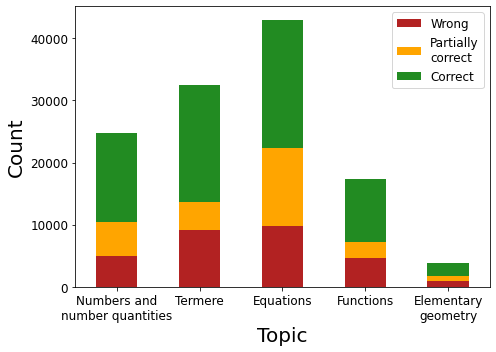

In [29]:
# Barplot of the trials per topic per evaluation
fig, ax = plt.subplots(figsize=(7,5))

(trials_partial_all_df.groupby(['parent_topic_id', 'evaluation']).size().unstack()
                      .plot(kind='bar', stacked=True, fontsize=12, color=['firebrick', 'orange', 'forestgreen'], ax=ax))

#labels = [id_to_name[int(tick.get_text())] for tick in ax.get_xticklabels()]
labels = ["Numbers and\nnumber quantities", "Termere", "Equations", "Functions", "Elementary\ngeometry"]
#ax.set_title('Evaluation per topic\n')
ax.set_xlabel('Topic', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.set_xticklabels(labels, rotation=0)
ax.legend(['Wrong', 'Partially\ncorrect', 'Correct'], fontsize=12)

plt.tight_layout()
plt.savefig('evaluation_per_topic')
plt.show()

**Discussion**  
This visualisation reveals several interesting characteristics of our data:

* There is a large imbalance in the distribution of data per topic
* Most of the trials are correct, but partially correct answers is also well represented in nearly every topic. It means that the these trials may have a non-negligeable impact depending on how we treat them.

Now let's see how the data are distributed considering the estimated difficulty.

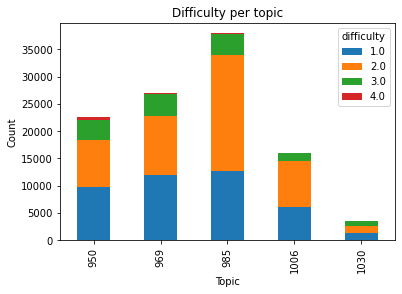

In [30]:
# Barplot of the trials per topic per difficulty
trials_partial_all_df.groupby(['parent_topic_id', 'difficulty']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Difficulty per topic')
plt.xlabel('Topic')
plt.ylabel('Count')
#plt.xticks(np.arange(5), labels=MAIN_TOPICS)
#plt.legend(['Correct', 'Partially\ncorrect', 'Wrong'])
plt.show()

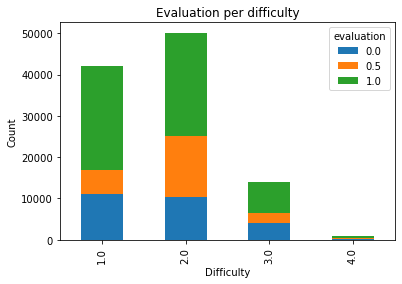

In [37]:
# Barplot of the trials per topic per evaluation
trials_partial_all_df.groupby(['difficulty', 'evaluation']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Evaluation per difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Count')
#plt.yscale('log')
#plt.xticks(np.arange(5), labels=MAIN_TOPICS)
#plt.legend(['Correct', 'Partially\ncorrect', 'Wrong'])
plt.show()

**Discussion**  
These two visualisations reveal additional interesting characteristics of our data:

* There is approximately the same distribution of difficulty per parent topic
* The evaluation per difficulty does not give us any useful information, except that the distribution is not as expected. In general, we expect that the harder the question, the lower the success rate, but it is surprisingly not the case here.

## 2 - Model Building


We consider several knowledge tracing models in an attempt to mimic Learnavi users. Each of these models have some assumptions, some pros and cons.  
Note that by nature, some of these models are not really comparable (e.g. BKT where one model corresponds to one skill and DKT where one model is built taking all the skills into account). However, we are interested in the model(s) that represents the best the users behavior.

### 2.1 Bayesian Knowledge Tracing (BKT)

BKT rely on the assumption that knowledge can be divided into different skills and that each task corresponds to a single skill. Also, the skills are supposed to be completely disconnected (mastering one skill should not impact the level of understanding on another skill).  
To satisfy this condition, we fit one model per parent topic, which ensures that the overlap between skills is minimized. Note that a student cannot forget a skill once it is learned, and the model only supports binary outcomes.

In [175]:
bkt_rmse_means, bkt_rmse_stds = [], []
bkt_auc_means, bkt_auc_stds = [], []
bkt_models = {}

for t in MAIN_TOPICS:
    print('Topic: ', t)

    # Train and evaluate the model on different split of the data
    bkt_model, bkt_rmse, bkt_auc = train_bkt(trials_bin_per_topic_dict[t])
    
    # Store the mean/std rmse and auc
    bkt_rmse_means.append(np.mean(bkt_rmse))
    bkt_auc_means.append(np.mean(bkt_auc))
    bkt_rmse_stds.append(np.std(bkt_rmse))
    bkt_auc_stds.append(np.std(bkt_auc))
    
    # Store the model per topic
    bkt_models[t] = bkt_model
    print('-----------------------------------')

Topic:  Functions
Split 0 : RMSE = 0.462 AUC = 0.699
Split 1 : RMSE = 0.460 AUC = 0.705
Split 2 : RMSE = 0.461 AUC = 0.704
Split 3 : RMSE = 0.460 AUC = 0.702
Split 4 : RMSE = 0.462 AUC = 0.700

Mean RMSE (std): 0.460 (0.003)
Mean AUC (std): 0.705, (0.012)
-----------------------------------
Topic:  Numbers and number quantities
Split 0 : RMSE = 0.476 AUC = 0.655
Split 1 : RMSE = 0.476 AUC = 0.655
Split 2 : RMSE = 0.475 AUC = 0.655
Split 3 : RMSE = 0.474 AUC = 0.658
Split 4 : RMSE = 0.476 AUC = 0.656

Mean RMSE (std): 0.479 (0.002)
Mean AUC (std): 0.647, (0.007)
-----------------------------------
Topic:  Equations
Split 0 : RMSE = 0.471 AUC = 0.692
Split 1 : RMSE = 0.470 AUC = 0.694
Split 2 : RMSE = 0.472 AUC = 0.689
Split 3 : RMSE = 0.472 AUC = 0.688
Split 4 : RMSE = 0.471 AUC = 0.692

Mean RMSE (std): 0.473 (0.003)
Mean AUC (std): 0.684, (0.010)
-----------------------------------
Topic:  Elementary geometry
Split 0 : RMSE = 0.478 AUC = 0.658
Split 1 : RMSE = 0.483 AUC = 0.638
Split 

### 2.2 Additive Factors Model (AFM)

AFM assumes that the prior knowledge of students may vary (random effect) and incorporates skill difficulty. It also considers that each student will learn a task at the same pace, but that a task can use multiple skills. Finally, it also relies on the fact that each new opportunity improves the learning.

In [176]:
# %load_ext rpy2.ipython

In [177]:
# %%R
# install.packages('lme4')

In [178]:
# Initialize and fit the model
afm_model = Lmer(
    "evaluation ~ (1|user_id) + (1|topic_id) + (0 + prev_attempts|topic_id)", 
    data=X_train_val, family='binomial'
)
afm_model.fit() 

Formula: evaluation~(1|user_id)+(1|topic_id)+(0+prev_attempts|topic_id)

Family: binomial	 Inference: parametric

Number of observations: 95910	 Groups: {'user_id': 4153.0, 'topic_id': 92.0}

Log-likelihood: -60855.999 	 AIC: 121719.998

Random effects:

                     Name     Var     Std
user_id       (Intercept) 0.41800 0.64700
topic_id      (Intercept) 0.28900 0.53800
topic_id.1  prev_attempts 0.00200 0.04700

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.02500,-0.09100,0.14200,0.05900,1.02600,0.91300,1.15300,0.50600,0.47700,0.53500,0.42900,0.66800,


In [179]:
# Compute predictions for test set
X_test['afm_predictions'] = afm_model.predict(data=X_test, verify_predictions=False)

### 2.3 Performance Factors Analysis (PFA)

#### 2.3.1 Original PFA (binary evaluation)

PFA is a model similar to AFM, but now each opportunities does not improve the learning in the same way. It assumes that the learning rate is different for correct and wrong answers.  
Our AFM and PFA models assume that a question only belongs to the topic it is directly assigned. 

In [180]:
# Initialize and fit the model
pfa_model = Lmer(
    "evaluation ~ (1|user_id) + (1|topic_id) + (0 + prev_correct_attempts|topic_id) + \
    (0 + prev_wrong_attempts|topic_id)", data=X_train_val, family='binomial'
)
pfa_model.fit() 

Formula: evaluation~(1|user_id)+(1|topic_id)+(0+prev_correct_attempts|topic_id)+(0+prev_wrong_attempts|topic_id)

Family: binomial	 Inference: parametric

Number of observations: 95910	 Groups: {'user_id': 4153.0, 'topic_id': 92.0}

Log-likelihood: -60661.439 	 AIC: 121332.877

Random effects:

                             Name     Var     Std
user_id               (Intercept) 0.34600 0.58800
topic_id              (Intercept) 0.27700 0.52700
topic_id.1  prev_correct_attempts 0.00700 0.08500
topic_id.2    prev_wrong_attempts 0.00500 0.07000

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.02300,-0.09100,0.13700,0.05800,1.02400,0.91300,1.14700,0.50600,0.47700,0.53400,0.40300,0.68700,


In [181]:
# Compute predictions for test set
X_test['pfa_predictions'] = pfa_model.predict(data=X_test, verify_predictions=False)

#### 2.3.2 Extended PFA (with estimated difficulty)

In [182]:
# Initialize and fit the model
# TODO: check with TA if incorporating difficulty this way (1|...) is sensible
pfa_ed_model = Lmer(
    "evaluation ~ (1|user_id) + (1|topic_id) + (1|difficulty) + (0 + prev_correct_attempts|topic_id) + \
     (0 + prev_wrong_attempts|topic_id)", 
    data=X_train_val, family='binomial'
)
pfa_ed_model.fit() 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: evaluation~(1|user_id)+(1|topic_id)+(1|difficulty)+(0+prev_correct_attempts|topic_id)+(0+prev_wrong_attempts|topic_id)

Family: binomial	 Inference: parametric

Number of observations: 95910	 Groups: {'user_id': 4134.0, 'topic_id': 91.0, 'difficulty': 4.0}

Log-likelihood: -53283.421 	 AIC: 106578.842

Random effects:

                             Name     Var     Std
user_id               (Intercept) 0.37300 0.61100
topic_id      prev_wrong_attempts 0.00500 0.07400
topic_id.1  prev_correct_attempts 0.01000 0.10200
topic_id.2            (Intercept) 0.28400 0.53300
difficulty            (Intercept) 0.08600 0.29300

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.16400,-0.47700,0.14800,0.15900,0.84900,0.62100,1.16000,0.45900,0.38300,0.53700,-1.03100,0.30300,


In [183]:
# Compute predictions for test set
X_test['pfa_ed_predictions'] = pfa_ed_model.predict(data=X_test, verify_predictions=False)

#### 2.3.3 Extended PFA (with partial evaluation)

In [184]:
# Initialize and fit the model
pfa_pe_model = Lmer(
    "evaluation ~ (1|user_id) + (1|topic_id) + (0 + prev_correct_attempts|topic_id) + \
    (0 + prev_partial_attempts|topic_id) + (0 + prev_wrong_attempts|topic_id)", 
    data=X_partial_train_val, family='binomial'
)
pfa_pe_model.fit() 

boundary (singular) fit: see ?isSingular 

Formula: evaluation~(1|user_id)+(1|topic_id)+(0+prev_correct_attempts|topic_id)+(0+prev_partial_attempts|topic_id)+(0+prev_wrong_attempts|topic_id)

Family: binomial	 Inference: parametric

Number of observations: 95910	 Groups: {'user_id': 4153.0, 'topic_id': 92.0}

Log-likelihood: -64792.883 	 AIC: 129597.766

Random effects:

                             Name     Var     Std
user_id               (Intercept) 0.08200 0.28600
topic_id              (Intercept) 0.00000 0.00000
topic_id.1  prev_correct_attempts 0.00400 0.06300
topic_id.2  prev_partial_attempts 0.00000 0.00000
topic_id.3    prev_wrong_attempts 0.00500 0.06900

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.04800,0.02800,0.06700,0.01000,1.04900,1.02900,1.07000,0.51200,0.50700,0.51700,4.78400,0.00000,***


In [185]:
# Compute predictions for test set
X_partial_test['pfa_pe_predictions'] = pfa_pe_model.predict(data=X_partial_test, verify_predictions=False)

#### 2.3.4 Extended PFA (with partial evaluation & estimated difficulty)

In [186]:
# Initialize and fit the model
pfa_pe_ed_model = Lmer(
    "evaluation ~ (1|user_id) + (1|topic_id) + (1|difficulty) + (0 + prev_correct_attempts|topic_id) + \
    (0 + prev_partial_attempts|topic_id) + (0 + prev_wrong_attempts|topic_id)", 
    data=X_partial_train_val, family='binomial'
)
pfa_pe_ed_model.fit() 

Model failed to converge with max|grad| = 0.00217509 (tol = 0.001, component 1) 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: evaluation~(1|user_id)+(1|topic_id)+(1|difficulty)+(0+prev_correct_attempts|topic_id)+(0+prev_partial_attempts|topic_id)+(0+prev_wrong_attempts|topic_id)

Family: binomial	 Inference: parametric

Number of observations: 95910	 Groups: {'user_id': 4134.0, 'topic_id': 91.0, 'difficulty': 4.0}

Log-likelihood: -57603.537 	 AIC: 115221.074

Random effects:

                             Name     Var     Std
user_id               (Intercept) 0.25900 0.50900
topic_id      prev_wrong_attempts 0.00600 0.07500
topic_id.1  prev_partial_attempts 0.00200 0.04000
topic_id.2  prev_correct_attempts 0.00900 0.09300
topic_id.3        

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.08600,-0.19000,0.01800,0.05300,0.91700,0.82700,1.01800,0.47800,0.45300,0.50500,-1.61800,0.10600,


In [187]:
# Compute predictions for test set
X_partial_test['pfa_pe_ed_predictions'] = pfa_pe_ed_model.predict(data=X_partial_test, verify_predictions=False)

### 2.4 Deep Knowledge Tracing (DKT)
In this section, we consider a neural network for knowledge tracing. Deep Knowledge Tracing allows for flexible models that can capture relationships between different topics. To that end, we fit a RNN model (also considering the variants – LSTM and GRU) to the dataset with all the data that belong to the 5 main topics.

We train the network for 20 epochs with early stopping and Adam optimizer.

In [32]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [33]:
# Define the parameters of our model
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 16 # tuned
params['epochs'] = 20
params['dropout_rate'] = 0.22291366459641143 # tuned
params['activation'] = 'sigmoid'
params['metrics'] = [MultiAUC(), RMSE()]
params['loss_fn'] = CustomMeanSquaredError
params['backbone_nn'] = tf.keras.layers.GRU

2022-05-22 14:03:16.588238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The data is preprocessed for the model by generating sequences for each user. Each topic is first encoded as a category. Then, we create a feature which has the size of `2 * #topics` such that one half corresponds to correctly answered topics and the other to incorrect answers. The sequences are then shifted by 1 and padded in each batch using a masking parameter, to indicate that a value should not be considered.

If partial credit is considered, the features have shape `3 * #topics`. We also try to include the difficulty of the question as a feature.

In [34]:
# Impute missing difficulty level with the most common value
trials_partial_all_df['difficulty'].fillna(trials_partial_all_df['difficulty'].mode()[0], inplace=True)
trials_bin_all_df['difficulty'].fillna(trials_bin_all_df['difficulty'].mode()[0], inplace=True)

In [35]:
def generate_features(df, params, incl_difficulty=False): # Whether or not to include difficulty of the question

    seq, features_depth, skill_depth = prepare_seq(df)
    seq_train = seq[X_train.user_id.unique()]
    seq_val = seq[X_val.user_id.unique()]
    seq_test = seq[X_test.user_id.unique()]

    # Prepare the training, validation, and test data in the DKT input format
    tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth, incl_difficulty)
    tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth, incl_difficulty)
    tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth, incl_difficulty)

    # Calculate the length of each of the train-test-val sets and store as parameters
    params['train_size'] = int(length // params['batch_size'])
    params['val_size'] = int(val_length // params['batch_size'])
    params['test_size'] = int(test_length // params['batch_size'])

    num_features = features_depth + int(incl_difficulty)

    return tf_train, tf_val, tf_test, num_features, skill_depth, params

We use [Optuna](https://optuna.org/) to tune the hyperparameters. This framework automates the hyperparameter tuning and efficiently explores the search space. It is however expensive to run many trials, so we restrict the search space to [4, 8, 16, 32] recurrent units and droput between 0.001 and 0.5, as we do not expect strong regularization will be needed with the small amount of data that we have at hand. We run 25 trials with pruning (i.e. an unpromissing trial may be stopped early). Moreover, the tuning will stop if no improvement is found in the 5 last trials.

In [38]:
def objective(trial):
    tf.keras.backend.clear_session()

    recurrent_units = trial.suggest_categorical("recurrent_units", [4, 8, 16, 32])
    dropout_rate = trial.suggest_float("dropout_rate", 1e-3, 0.5, log=True) # dropout in [0.001, 0.5]
    params['recurrent_units'] = recurrent_units
    params['dropout_rate'] = dropout_rate
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5),
        optuna.integration.TFKerasPruningCallback(trial, "val_loss") # prune unpromising trials
    ]

    dkt = create_model(num_features, skill_depth, params)
    history = dkt.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size']-1, 
                    validation_data=tf_val, validation_steps=params['val_size'], verbose=False,
                    callbacks=callbacks)

    return history.history["val_loss"][-1]

In [39]:
if RUN_OPTUNA:
    partial_credit =  [False, True]
    incl_difficulty = [False, True]
    backbone = [tf.keras.layers.SimpleRNN, tf.keras.layers.GRU, tf.keras.layers.LSTM]

    for pc in partial_credit:
        if pc:
            df = trials_partial_all_df
            params['loss_fn'] = CustomMeanSquaredError
            params['metrics'] = [MultiAUC(), RMSE()]
        else:
            df = trials_bin_all_df
            params['loss_fn'] = CustomBinaryCrossEntropy
            params['metrics'] = [AUC(), RMSE(), Recall(), Precision()]

        for diff in incl_difficulty:
            tf_train, tf_val, tf_test, num_features, skill_depth, params = generate_features(df, params, diff)
            for bb in backbone:
                params['backbone_nn'] = bb

                dkt = create_model(num_features, skill_depth, params)
                sampler = TPESampler(seed=0) # reproducibility
                study = optuna.create_study(sampler=sampler, study_name="Tuning dropout and number of units of DKT")
                study.optimize(objective, n_trials=25)

                params['recurrent_units'] = study.best_trial.params['recurrent_units']
                params['dropout_rate'] = study.best_trial.params['dropout_rate']

                ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], 
                                                              save_best_only=True, save_weights_only=True)

                history = dkt.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size']-1, 
                                  validation_data=tf_val, validation_steps=params['val_size'],
                                  callbacks=[ckp_callback], verbose=params['verbose'])
                dkt.load_weights(params['best_model_weights'])
                dkt_res = dkt.evaluate(tf_test, steps=params['test_size'], verbose=params['verbose'], return_dict=True)

                dkt_res.update(params)
                del dkt_res['metrics']
                dkt_res['loss_fn'] = dkt_res['loss_fn'].__name__
                dkt_res['backbone_nn'] = dkt_res['backbone_nn'].__name__
                dkt_res['partial_credit'] = pc
                dkt_res['include_difficulty'] = diff

                with open('./results.txt', 'a+') as f:
                    f.write(str(dkt_res) + '\n')

[I 2022-05-22 14:04:19,755] A new study created in memory with name: Tuning dropout and number of units of DKT
[I 2022-05-22 14:06:33,708] Trial 0 finished with value: 0.044543687254190445 and parameters: {'recurrent_units': 8, 'dropout_rate': 0.013913346327363716}. Best is trial 0 with value: 0.044543687254190445.
[I 2022-05-22 14:09:18,256] Trial 1 finished with value: 0.04411431401968002 and parameters: {'recurrent_units': 32, 'dropout_rate': 0.01083670267174957}. Best is trial 1 with value: 0.04411431401968002.
[I 2022-05-22 14:12:16,317] Trial 2 finished with value: 0.04530826583504677 and parameters: {'recurrent_units': 32, 'dropout_rate': 0.0015549777899775822}. Best is trial 1 with value: 0.04411431401968002.
[I 2022-05-22 14:14:45,745] Trial 3 finished with value: 0.044467419385910034 and parameters: {'recurrent_units': 16, 'dropout_rate': 0.22291366459641143}. Best is trial 1 with value: 0.04411431401968002.
[I 2022-05-22 14:17:19,676] Trial 4 finished with value: 0.045343633

Epoch 1/20
102/102 [==============================] - 16s 105ms/step - loss: 0.0523 - multi-auc: 0.7933 - root_mean_squared_error: 0.4407 - val_loss: 0.0505 - val_multi-auc: 0.7769 - val_root_mean_squared_error: 0.4412
Epoch 2/20
102/102 [==============================] - 8s 77ms/step - loss: 0.0495 - multi-auc: 0.7864 - root_mean_squared_error: 0.4336 - val_loss: 0.0471 - val_multi-auc: 0.7760 - val_root_mean_squared_error: 0.4250
Epoch 3/20
102/102 [==============================] - 9s 84ms/step - loss: 0.0481 - multi-auc: 0.7852 - root_mean_squared_error: 0.4238 - val_loss: 0.0465 - val_multi-auc: 0.7888 - val_root_mean_squared_error: 0.4217
Epoch 4/20
102/102 [==============================] - 9s 87ms/step - loss: 0.0470 - multi-auc: 0.7952 - root_mean_squared_error: 0.4206 - val_loss: 0.0461 - val_multi-auc: 0.7897 - val_root_mean_squared_error: 0.4200
Epoch 5/20
102/102 [==============================] - 11s 106ms/step - loss: 0.0469 - multi-auc: 0.7953 - root_mean_squared_error:

[I 2022-05-22 14:40:42,704] A new study created in memory with name: Tuning dropout and number of units of DKT
[I 2022-05-22 14:42:22,450] Trial 0 finished with value: 0.04444076865911484 and parameters: {'recurrent_units': 8, 'dropout_rate': 0.013913346327363716}. Best is trial 0 with value: 0.04444076865911484.
[I 2022-05-22 14:43:56,224] Trial 1 finished with value: 0.04526454582810402 and parameters: {'recurrent_units': 32, 'dropout_rate': 0.01083670267174957}. Best is trial 0 with value: 0.04444076865911484.
[I 2022-05-22 14:45:21,888] Trial 2 finished with value: 0.04466092959046364 and parameters: {'recurrent_units': 32, 'dropout_rate': 0.0015549777899775822}. Best is trial 0 with value: 0.04444076865911484.
[I 2022-05-22 14:47:05,709] Trial 3 finished with value: 0.04411287233233452 and parameters: {'recurrent_units': 16, 'dropout_rate': 0.22291366459641143}. Best is trial 3 with value: 0.04411287233233452.
[I 2022-05-22 14:48:47,898] Trial 4 finished with value: 0.045391868799

Epoch 1/20
102/102 [==============================] - 15s 94ms/step - loss: 0.0499 - multi-auc: 0.7865 - root_mean_squared_error: 0.4327 - val_loss: 0.0469 - val_multi-auc: 0.7615 - val_root_mean_squared_error: 0.4256
Epoch 2/20
102/102 [==============================] - 9s 91ms/step - loss: 0.0477 - multi-auc: 0.7772 - root_mean_squared_error: 0.4235 - val_loss: 0.0459 - val_multi-auc: 0.7828 - val_root_mean_squared_error: 0.4198
Epoch 3/20
102/102 [==============================] - 9s 89ms/step - loss: 0.0469 - multi-auc: 0.7937 - root_mean_squared_error: 0.4186 - val_loss: 0.0455 - val_multi-auc: 0.7789 - val_root_mean_squared_error: 0.4178
Epoch 4/20
102/102 [==============================] - 10s 97ms/step - loss: 0.0460 - multi-auc: 0.7950 - root_mean_squared_error: 0.4162 - val_loss: 0.0452 - val_multi-auc: 0.7816 - val_root_mean_squared_error: 0.4164
Epoch 5/20
102/102 [==============================] - 10s 97ms/step - loss: 0.0457 - multi-auc: 0.7987 - root_mean_squared_error: 

[I 2022-05-22 15:01:14,859] A new study created in memory with name: Tuning dropout and number of units of DKT
[I 2022-05-22 15:03:52,962] Trial 0 finished with value: 0.044409167021512985 and parameters: {'recurrent_units': 8, 'dropout_rate': 0.013913346327363716}. Best is trial 0 with value: 0.044409167021512985.
[I 2022-05-22 15:06:46,887] Trial 1 finished with value: 0.043606411665678024 and parameters: {'recurrent_units': 32, 'dropout_rate': 0.01083670267174957}. Best is trial 1 with value: 0.043606411665678024.
[I 2022-05-22 15:10:05,223] Trial 2 finished with value: 0.04384688287973404 and parameters: {'recurrent_units': 32, 'dropout_rate': 0.0015549777899775822}. Best is trial 1 with value: 0.043606411665678024.
[I 2022-05-22 15:12:53,693] Trial 3 finished with value: 0.04415933042764664 and parameters: {'recurrent_units': 16, 'dropout_rate': 0.22291366459641143}. Best is trial 1 with value: 0.043606411665678024.
[I 2022-05-22 15:15:31,242] Trial 4 finished with value: 0.045058

Epoch 1/20
102/102 [==============================] - 13s 90ms/step - loss: 0.0516 - multi-auc: 0.7813 - root_mean_squared_error: 0.4426 - val_loss: 0.0494 - val_multi-auc: 0.7729 - val_root_mean_squared_error: 0.4366
Epoch 2/20
102/102 [==============================] - 7s 72ms/step - loss: 0.0488 - multi-auc: 0.7763 - root_mean_squared_error: 0.4303 - val_loss: 0.0464 - val_multi-auc: 0.7771 - val_root_mean_squared_error: 0.4222
Epoch 3/20
102/102 [==============================] - 7s 74ms/step - loss: 0.0474 - multi-auc: 0.7902 - root_mean_squared_error: 0.4209 - val_loss: 0.0459 - val_multi-auc: 0.7799 - val_root_mean_squared_error: 0.4194
Epoch 4/20
102/102 [==============================] - 8s 80ms/step - loss: 0.0466 - multi-auc: 0.7931 - root_mean_squared_error: 0.4187 - val_loss: 0.0457 - val_multi-auc: 0.7791 - val_root_mean_squared_error: 0.4186
Epoch 5/20
102/102 [==============================] - 9s 88ms/step - loss: 0.0466 - multi-auc: 0.7940 - root_mean_squared_error: 0.

[I 2022-05-22 15:33:09,386] A new study created in memory with name: Tuning dropout and number of units of DKT
[I 2022-05-22 15:35:37,426] Trial 0 finished with value: 0.044894758611917496 and parameters: {'recurrent_units': 8, 'dropout_rate': 0.013913346327363716}. Best is trial 0 with value: 0.044894758611917496.
[I 2022-05-22 15:38:22,954] Trial 1 finished with value: 0.043867193162441254 and parameters: {'recurrent_units': 32, 'dropout_rate': 0.01083670267174957}. Best is trial 1 with value: 0.043867193162441254.
[I 2022-05-22 15:41:05,680] Trial 2 finished with value: 0.04436824470758438 and parameters: {'recurrent_units': 32, 'dropout_rate': 0.0015549777899775822}. Best is trial 1 with value: 0.043867193162441254.
[I 2022-05-22 15:43:45,908] Trial 3 finished with value: 0.04438285529613495 and parameters: {'recurrent_units': 16, 'dropout_rate': 0.22291366459641143}. Best is trial 1 with value: 0.043867193162441254.
[I 2022-05-22 15:46:17,071] Trial 4 finished with value: 0.045233

Epoch 1/20
102/102 [==============================] - 18s 130ms/step - loss: 0.0509 - multi-auc: 0.7837 - root_mean_squared_error: 0.4376 - val_loss: 0.0477 - val_multi-auc: 0.7725 - val_root_mean_squared_error: 0.4290
Epoch 2/20
102/102 [==============================] - 12s 117ms/step - loss: 0.0483 - multi-auc: 0.7877 - root_mean_squared_error: 0.4265 - val_loss: 0.0463 - val_multi-auc: 0.7804 - val_root_mean_squared_error: 0.4216
Epoch 3/20
102/102 [==============================] - 12s 115ms/step - loss: 0.0474 - multi-auc: 0.7950 - root_mean_squared_error: 0.4203 - val_loss: 0.0458 - val_multi-auc: 0.7868 - val_root_mean_squared_error: 0.4190
Epoch 4/20
102/102 [==============================] - 11s 105ms/step - loss: 0.0463 - multi-auc: 0.7977 - root_mean_squared_error: 0.4170 - val_loss: 0.0455 - val_multi-auc: 0.7892 - val_root_mean_squared_error: 0.4173
Epoch 5/20
102/102 [==============================] - 12s 123ms/step - loss: 0.0460 - multi-auc: 0.8026 - root_mean_squared_

Below we re-fit and re-evaluate the best model:

In [36]:
tf_train, tf_val, tf_test, num_features, skill_depth, params = generate_features(trials_bin_all_df, params, False)

In [37]:
# Build and inspect the model
dkt = create_model(num_features, skill_depth, params)
dkt.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 184)]       0         
                                                                 
 masking (Masking)           (None, None, 184)         0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          12864     
                                                                 
 outputs (TimeDistributed)   (None, None, 91)          1547      
                                                                 
Total params: 14,411
Trainable params: 14,411
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# (Re)-fit the best model with the best parameters
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], 
                                                  save_best_only=True, save_weights_only=True)

history = dkt.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size']-1, 
                       validation_data=tf_val, validation_steps=params['val_size'],
                       callbacks=[ckp_callback], verbose=params['verbose'])

102/102 [==============================] - 11s 72ms/step - loss: 0.2446 - auc: 0.5715 - root_mean_squared_error: 0.5014 - recall: 0.5560 - precision: 0.5922 - val_loss: 0.2330 - val_auc: 0.6127 - val_root_mean_squared_error: 0.4980 - val_recall: 0.6630 - val_precision: 0.6226


Finally, evaluate the model on the test set:

In [ ]:
dkt.load_weights(params['best_model_weights'])
dkt_res = dkt.evaluate(tf_test, steps=params['test_size'], verbose=params['verbose'], return_dict=True)

32/32 [==============================] - 1s 22ms/step - loss: 0.2165 - auc: 0.6182 - root_mean_squared_error: 0.4982 - recall: 0.6771 - precision: 0.6173


## 3 - Model Evaluation

### 3.1 Bayesian Knowledge Tracing (BKT)

#### 3.1.1 RMSE and AUC

In [ ]:
results = pd.DataFrame([bkt_rmse_means, bkt_rmse_stds, bkt_auc_means, bkt_auc_stds]).transpose()
results.columns = ['bkt_mean_rmse', 'bkt_std_rmse', 'bkt_mean_auc', 'bkt_std_auc']
results[['bkt_mean_rmse']].plot(kind='bar', yerr = results[['bkt_std_rmse']].values.T, legend=None)
plt.xticks(np.arange(len(MAIN_TOPICS)), MAIN_TOPICS)
plt.ylabel('RMSE')
plt.show()

results[['bkt_mean_auc']].plot(kind='bar', yerr = results[['bkt_std_auc']].values.T, legend=None)
plt.xticks(np.arange(len(MAIN_TOPICS)), MAIN_TOPICS)
plt.ylabel('AUC')
plt.show()

**Discussion**  
We observe that the models vary depending on the topic. For example, the model fitted on the `Functions` skill has a good accuracy, whereas the models fitted on `Elementary geometry` and `Temere` are a bit less accurate.  
Note here that the models fitted on the topics containing more data are more accurate.

#### 3.1.2 Learning curves

In [ ]:
for t in MAIN_TOPICS:
    preds = bkt_models[t].predict(data=trials_bin_per_topic_dict[t])[['user_id', 'topic_id', 'evaluation', 'correct_predictions']]
    preds.columns = ['user_id', 'skill_name', 'y_true', 'y_pred_bkt']
    plot_learning_curve(preds, title='Learning curve for ' + t)

**Discussion**  

• **Functions**: Looking at the ground truth data (in blue), we see that the initial error rate (for early stages,
where the data are most reliable) is just below 0.5. The errors rate then decreases slightly as the students
practice more questions, but starts increasing again after around 20 questions. This may be because more
difficult questions are given to the user from Lernnavi to challenge him/her. The data become too noisy
after around 50 questions, as there are not many students left who answered at least this many questions.
The confidence interval becomes too wide after that point and therefore there may be large discrepancies
between students, and the BKT model (orange), although offering a good fit in the early stages (especially
until question 25), is no longer very accurate. Note that the number of students still involved with the topic
goes down after 12 practice questions.  

• **Number quantities**: Starting at around 0.5 error rate, we notice a small improvement in the Number
quantities knowledge after the first few questions. However the error rate is not very stable already from the
start, indicating there are be large discrepancies among users, which are further emphasized once the sample
size is reduced (after a 10-20 questions.  

• **Equations**: This topic seems to be on the more challenging side at first, with error rate around 0.6. The
users then improve fast, as the ground truth error rate drops below 0.5 within 20 practice questions. The error
rate is stable until about 50 questions, then gets wider and therefore it becomes hard to draw conclusions
from the later stages, the BKT fit however suggests that the users do improve their skills over time, despite
the uptake being reduced significantly after 10-20 questions.  

• **Elementary geometry**: Users studying geometry seem to plateau around a 0.5 error rate in the early
stages, then start improving slightly once they have answered at least 10 questions. The confidence interval
is wider than for the other topics are fewer students engage in geometry overall. Again, we observe from the
histogram that the dropout rate is high after 4-5 questions, so users give up very fast.
  
• **Termere**: The learning curve for Terms does not exhibit much trends, which means the performance remains
unchanged as users are answering more questions. If the difficulty is not progressively increasing, this could
indicate that there is little learning going on, otherwise the difficulty is increased in an adequate way. There
is no obvious point at which most users leave, we observe an exponential dropout rate.  

Overall BKT provides a good fit, however tends to underestimate the error rate at times. In all of the plots,
the fast oscillations in the later stages are due to the reduced sample size as many uses stop practicing

### 3.2 Additive Factors Model (AFM)

In [ ]:
afm_rmse, afm_auc = compute_metrics(X_test, "pfa_predictions")
afm_metrics_mean, afm_metrics_std, afm_metrics = compute_metrics_per_topic(X_test, "parent_topic_id", "afm_predictions")

print('Overall:')
print(f"  RMSE: {afm_rmse:.3f}")
print(f"  AUC: {afm_auc:.3f}\n")

print('Per Topic:')
print(f"  RMSE: {afm_metrics_mean['rmse']:.3f} ({afm_metrics_std['rmse']:.3f})")
print(f"  AUC: {afm_metrics_mean['auc']:.3f} ({afm_metrics_std['auc']:.3f})\n")

afm_metrics

Overall:
  RMSE: 0.480
  AUC: 0.651

Per Topic:
  RMSE: 0.486 (0.009)
  AUC: 0.614 (0.044)



,rmse,auc
0,0.48096,0.63647
1,0.49001,0.58182
2,0.47877,0.66096
3,0.47951,0.63784
4,0.50090,0.55450


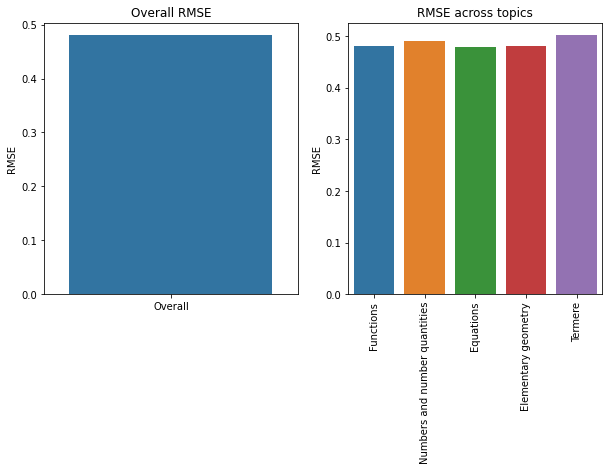

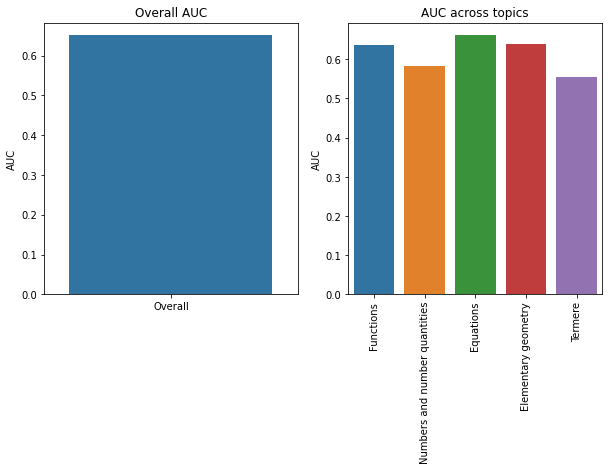

In [ ]:
plot_metrics(afm_rmse, afm_metrics['rmse'], afm_auc, afm_metrics['auc'], MAIN_TOPICS)

**Discussion**  
AFM model performs worse on every topics in comparison to BKT. Though, it has the advantage to wrap every topics in one model.

### 3.3 Performance Factors Analysis (PFA)

#### 3.3.1 Original PFA

In [ ]:
pfa_rmse, pfa_auc = compute_metrics(X_test, "pfa_predictions")
pfa_metrics_mean, pfa_metrics_std, pfa_metrics = compute_metrics_per_topic(X_test, "parent_topic_id", "pfa_predictions")

print('Overall:')
print(f"  RMSE: {pfa_rmse:.3f}")
print(f"  AUC: {pfa_auc:.3f}\n")

print('Per Topic:')
print(f"  RMSE: {pfa_metrics_mean['rmse']:.3f} ({pfa_metrics_std['rmse']:.3f})")
print(f"  AUC: {pfa_metrics_mean['auc']:.3f} ({pfa_metrics_std['auc']:.3f})\n")

pfa_metrics

Overall:
  RMSE: 0.480
  AUC: 0.651

Per Topic:
  RMSE: 0.483 (0.011)
  AUC: 0.631 (0.046)



,rmse,auc
0,0.47710,0.65768
1,0.48639,0.60247
2,0.47729,0.66734
3,0.47408,0.66134
4,0.50018,0.56368


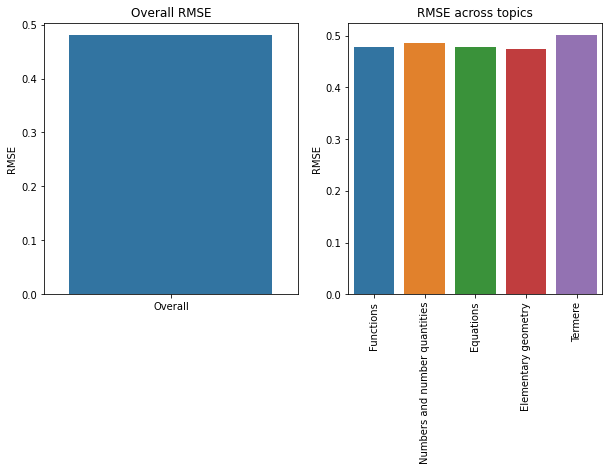

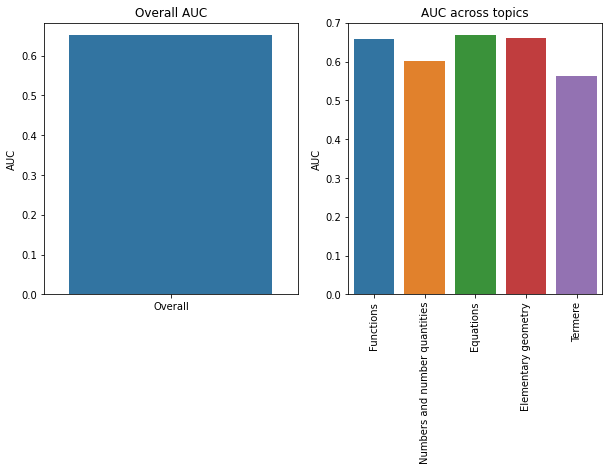

In [ ]:
plot_metrics(pfa_rmse, pfa_metrics['rmse'], pfa_auc, pfa_metrics['auc'], MAIN_TOPICS)

**Discussion**  
PFA is slightly more accurate than AFM on every topic, showing that considering correct and wrong answers separatly helps the model to be more accurate in its prediction.  
These results motivate the exploration of a PFA model where we would also consider the the partially correct answers in the model separatly from the correct and the wrong answers.

#### 3.3.2 Extended PFA (with estimated difficulty)

In [ ]:
pfa_ed_rmse, pfa_ed_auc = compute_metrics(X_test, "pfa_ed_predictions")
pfa_ed_metrics_mean, pfa_ed_metrics_std, pfa_ed_metrics = compute_metrics_per_topic(X_test, "parent_topic_id", "pfa_ed_predictions")

print('Overall:')
print(f"  RMSE: {pfa_ed_rmse:.3f}")
print(f"  AUC: {pfa_ed_auc:.3f}\n")

print('Per Topic:')
print(f"  RMSE: {pfa_ed_metrics_mean['rmse']:.3f} ({pfa_ed_metrics_std['rmse']:.3f})")
print(f"  AUC: {pfa_ed_metrics_mean['auc']:.3f} ({pfa_ed_metrics_std['auc']:.3f})\n")

pfa_ed_metrics

Overall:
  RMSE: 0.479
  AUC: 0.656

Per Topic:
  RMSE: 0.481 (0.009)
  AUC: 0.642 (0.037)



,rmse,auc
0,0.47832,0.64996
1,0.48620,0.60447
2,0.47639,0.67535
3,0.47107,0.67666
4,0.49486,0.60192


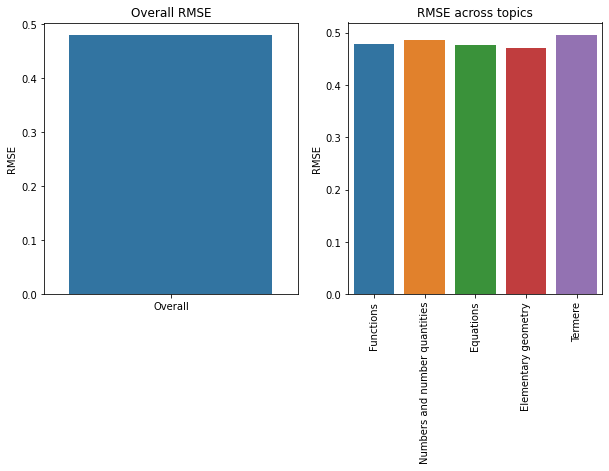

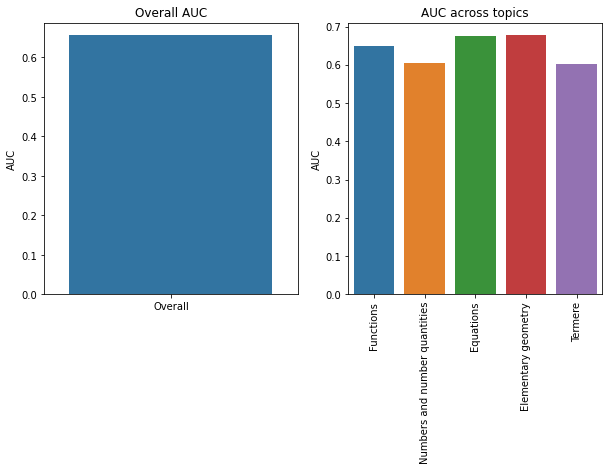

In [ ]:
plot_metrics(pfa_ed_rmse, pfa_ed_metrics['rmse'], pfa_ed_auc, pfa_ed_metrics['auc'], MAIN_TOPICS)

#### 3.3.3 Extended PFA (with partial evaluation)

In [ ]:
pfa_pe_rmse, pfa_pe_auc = compute_metrics(X_partial_test, "pfa_pe_predictions")
pfa_pe_metrics_mean, pfa_pe_metrics_std, pfa_pe_metrics = compute_metrics_per_topic(X_partial_test, "parent_topic_id", "pfa_pe_predictions")

print('Overall:')
print(f"  RMSE: {pfa_pe_rmse:.3f}")
print(f"  AUC: {pfa_pe_auc:.3f}\n")

print('Per Topic:')
print(f"  RMSE: {pfa_pe_metrics_mean['rmse']:.3f} ({pfa_pe_metrics_std['rmse']:.3f})")
print(f"  AUC: {pfa_pe_metrics_mean['auc']:.3f} ({pfa_pe_metrics_std['auc']:.3f})\n")

pfa_pe_metrics

Overall:
  RMSE: 0.422
  AUC: 0.516

Per Topic:
  RMSE: 0.423 (0.016)
  AUC: 0.517 (0.018)



,rmse,auc
0,0.41435,0.49627
1,0.44655,0.51336
2,0.40385,0.51953
3,0.43007,0.54558
4,0.42174,0.50880


#### 3.3.4 Extended PFA (with partial evaluation & estimated difficulty)

In [ ]:
pfa_pe_ed_rmse, pfa_pe_ed_auc = compute_metrics(X_partial_test, "pfa_pe_ed_predictions")
pfa_pe_ed_metrics_mean, pfa_pe_ed_metrics_std, pfa_pe_ed_metrics = compute_metrics_per_topic(X_partial_test, "parent_topic_id", "pfa_pe_ed_predictions")

print('Overall:')
print(f"  RMSE: {pfa_pe_ed_rmse:.3f}")
print(f"  AUC: {pfa_pe_ed_auc:.3f}\n")

print('Per Topic:')
print(f"  RMSE: {pfa_pe_ed_metrics_mean['rmse']:.3f} ({pfa_pe_ed_metrics_std['rmse']:.3f})")
print(f"  AUC: {pfa_pe_ed_metrics_mean['auc']:.3f} ({pfa_pe_ed_metrics_std['auc']:.3f})\n")

pfa_pe_ed_metrics

Overall:
  RMSE: 0.407
  AUC: 0.532

Per Topic:
  RMSE: 0.409 (0.016)
  AUC: 0.526 (0.029)



,rmse,auc
0,0.39305,0.49505
1,0.43227,0.49375
2,0.39400,0.55728
3,0.41307,0.54134
4,0.41016,0.54226


### 3.4 Deep Knowledge Tracing (DKT)

In [ ]:
print("AUC: ", dkt_res['auc'])
print("RMSE: ", dkt_res['root_mean_squared_error'])

**Discussion**  

DKT model yields the highest accuracy among the models that are fitted on the whole data (i.e AFM, PFA and DKT). It performs similarly as BKT does, but has the benefit to include every topics in one model.  
We would have expected a more accurate result for DKT and think that the following elements might have an impact on the performance of DKT:

* DKT is a **deep** neural network and therefore requires much more data than the other models that have a lot less parameters.
* The quality of the data may not be very high as we have taken every data available from Learnavi and therefore there might be an upper bound on how much an ideal model would perform on these data. It may be be worth considering a subset of the data where the users completed the tasks in a more controlled environnement (cf. class feature).

The output of the network doesn't need to be limited to correct/wrong. In fact, since we already have instances of partially correct answers, we could use them instead of making the simplifying assumption that they are completely wrong. In fact, during experimentations, we found that the models were better at predicting whether the answer will be at least partially correct, i.e. if we assign partially correct the label 1 in the experiments above. This suggests that there is room for improvement, in addition to providing more features to the model, e.g. question difficulty as estimated by the platform. 